<a href="https://colab.research.google.com/github/hissain/mlworks/blob/main/codes/Transformers_basic_Architecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Architecture

#Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt

# Word Embedding

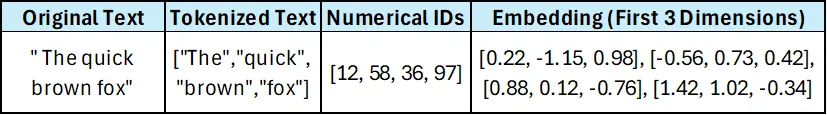

In [ ]:
class Embedding(nn.Module):
    def __init__(self, vocab_size, embed_size):
        """
        Initialize the Embedding layer.

        Parameters:
        - vocab_size (int): The size of the vocabulary, i.e., the total number of unique tokens.
        - embed_dim (int): The dimensionality of the embedding vectors.
        """
        super(Embedding, self).__init__()
        # The embedding layer converts input tokens (word indices) into dense vectors.
        # It helps the model represent and understand the semantic meaning of words.
        self.embedding = nn.Embedding(vocab_size, embed_size)

    def forward(self, x):
        """
        Forward pass of the Embedding layer.

        Parameters:
        - x (torch.Tensor): Input tensor containing token indices.

        Returns:
        - torch.Tensor: Output tensor with embedded representations of input tokens.
        """
        # Input token indices are embedded to create dense vectors.
        embedded_output = self.embedding(x)

        return embedded_output

#Positional Encoding

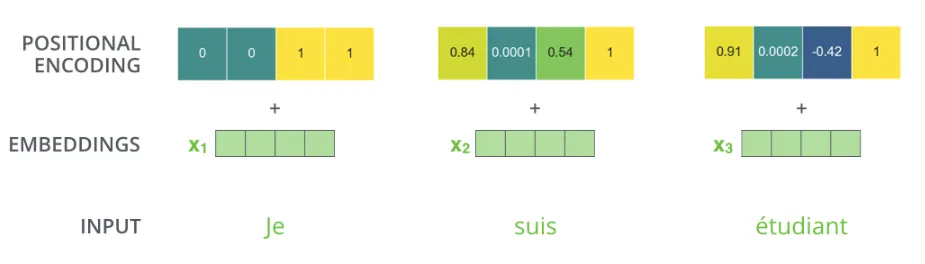


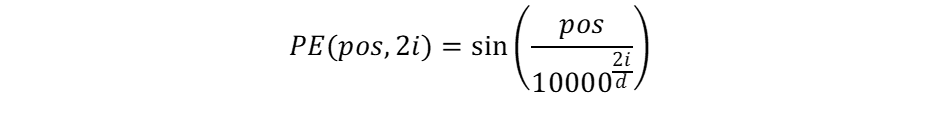

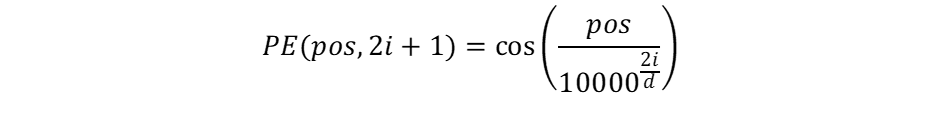

In [ ]:
class PositionalEncoding(nn.Module):
    """
    This module implements positional encoding for transformer models.

    Positional encoding is used to inject information about the position of tokens
    into the input embeddings. This allows the model to take into account the
    sequential order of tokens in the input.

    Args:
        embed_size (int): The dimensionality of the input embeddings.
        max_len (int, optional): The maximum length of the input sequence.
            Defaults to 5000.

    Attributes:
        pe (torch.Tensor): The positional encoding matrix of shape `(max_len, embed_size)`.

    """

    def __init__(self, embed_size, max_len=5000):
        """
        Initializes the PositionalEncoding module.

        Args:
            embed_size (int): The dimensionality of the input embeddings.
            max_len (int, optional): The maximum length of the input sequence.
                Defaults to 5000.
        """
        super(PositionalEncoding, self).__init__()
        self.embed_dim = embed_size

        # Initialize the positional encoding matrix with zeros.
        pe = torch.zeros(max_len, embed_size)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, embed_size, 2).float() * -(math.log(10000.0) / embed_size))

        # Apply the sine and cosine functions to the positional encoding matrix.
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        # Add a batch dimension to the positional encoding matrix.
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Forward pass of the PositionalEncoding module.

        Args:
            x (torch.Tensor): The input tensor of shape `(seq_len, batch_size, embed_size)`.

        Returns:
            torch.Tensor: The tensor with positional encoding added, of shape `(seq_len, batch_size, embed_size)`.
        """
        # Make embeddings relatively larger
        x = x * math.sqrt(self.embed_dim)
        # Add constant to embedding
        seq_len = x.size(1)
        # Add positional encoding to the input tensor.
        x = x + torch.autograd.Variable(self.pe[:,:seq_len], requires_grad=False)
        return x

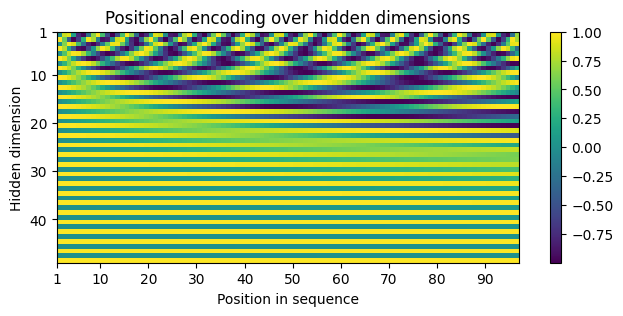

In [ ]:
# Instantiate the Positional Encoding module with specific parameters
encod_block = PositionalEncoding(embed_size=48, max_len=96)
pe = encod_block.pe.squeeze().cpu().numpy().T

# Plotting the Positional Encoding with a different color map
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,3))
pos = ax.imshow(pe, cmap="viridis", extent=(1, pe.shape[1] + 1, pe.shape[0] + 1, 1))
fig.colorbar(pos, ax=ax)
ax.set_xlabel("Position in sequence")
ax.set_ylabel("Hidden dimension")
ax.set_title("Positional encoding over hidden dimensions")
ax.set_xticks([1] + [i * 10 for i in range(1, 1 + pe.shape[1] // 10)])
ax.set_yticks([1] + [i * 10 for i in range(1, 1 + pe.shape[0] // 10)])
plt.show()

#Self Attention

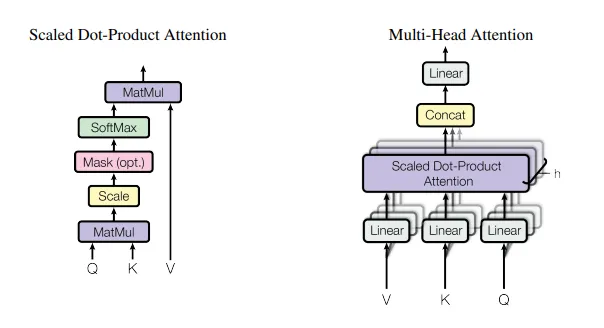

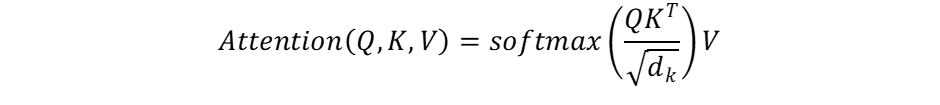

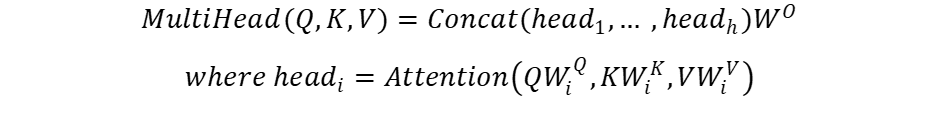

In [ ]:
class MultiHeadAttention(nn.Module):
    """
    Multi-head attention mechanism for transformer models.

    Multi-head attention allows the model to focus on different parts of the input
    sequence independently by splitting the embedding into multiple heads running in parallel.

    Args:
        embed_size (int): The dimensionality of the input embeddings.
        num_heads (int): The number of attention heads.

    Attributes:
        embed_size (int): The dimensionality of the input embeddings.
        num_heads (int): The number of attention heads.
        head_dim (int): The dimensionality of each attention head.
        query_projection (nn.Linear): Linear layer for projecting queries.
        key_projection (nn.Linear): Linear layer for projecting keys.
        value_projection (nn.Linear): Linear layer for projecting values.
        output_projection (nn.Linear): Linear layer for projecting concatenated attention outputs.

    """

    def __init__(self, embed_size=512, num_heads=8):

        """
        Initializes the MultiHeadAttention module.

        Args:
            embed_size (int): The dimensionality of the input embeddings, Default to 512.
            num_heads (int): The number of attention heads, Default to 8.
        """

        super(MultiHeadAttention, self).__init__()
        assert embed_size % num_heads == 0, "Embedding size must be divisible by number of heads"
        self.embed_size = embed_size # 512 by default
        self.num_heads = num_heads # 8 by default
        self.head_dim = int(embed_size / num_heads) # 512/8 = 64 by default

        # Linear transformations for queries, keys, and values
        self.query_projection = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.key_projection = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.value_projection = nn.Linear(self.head_dim, self.head_dim, bias=False)

        # Linear transformation for output projection (8*64)x512 or 512x512
        self.output_projection = nn.Linear(num_heads * self.head_dim, embed_size)

    def forward(self, values, keys, queries, mask=None):
        """
        Forward pass of the MultiHeadAttention module.

        Args:
            values (torch.Tensor): Input tensor of values, shape `(seq_length, batch_size, embed_size)`.
            keys (torch.Tensor): Input tensor of keys, shape `(seq_length, batch_size, embed_size)`.
            queries (torch.Tensor): Input tensor of queries, shape `(seq_length, batch_size, embed_size)`.
            mask (torch.Tensor, optional): Optional tensor with mask values, indicating elements to mask
                in the attention computation. Defaults to None.

        Returns:
            torch.Tensor: Output tensor after applying multi-head attention, shape `(seq_length, batch_size, embed_size)`.
        """

        # Extracting dimensions from the input tensors
        # N: Batch size or Number of sequences in the batch
        # value_len: Length of the sequence in the 'values' tensor
        # key_len: Length of the sequence in the 'keys' tensor
        # query_len: Length of the sequence in the 'queries' tensor
        # Input Size Format: (Batch Size, Sequence Length, Embedding Dimensions)
        N, value_len, key_len, query_len = queries.shape[0], values.shape[1], keys.shape[1], queries.shape[1]

        # Split the embedding into 'num_heads' pieces
        # Reshape the input tensors to enable multi-head attention
        # From: (Batch Size, Sequence Length, Embedding Dimensions)
        # To: (Batch Size, Sequence Length, num_heads, head_dim)
        # Example: Reshape (32x10x512) to (32x10x8x64)
        values = values.reshape(N, value_len, self.num_heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.num_heads, self.head_dim)
        queries = queries.reshape(N, query_len, self.num_heads, self.head_dim)

        # Linear projection for values, keys, and queries
        values = self.value_projection(values)
        keys = self.key_projection(keys)
        queries = self.query_projection(queries)

        # Transpose keys for efficient matrix multiplication
        keys_transpose = keys.transpose(-2, -1)

        # Scaled Dot-Product Attention
        scaled_scores = torch.matmul(queries, keys_transpose)

        # Masking
        if mask is not None:
            scaled_scores = scaled_scores.masked_fill(mask == 0, float("-1e20"))

        # Scale scores and apply softmax to obtain attention weights
        scaled_scores = scaled_scores * (1.0 / math.sqrt(self.head_dim))
        attention_weights = F.softmax(scaled_scores, dim=-1)

        # Weighted sum of values based on attention weights
        attention_output = torch.matmul(attention_weights, values)
        attention_output = attention_output.transpose(1, 2).contiguous().view(N, value_len, self.single_head_dim * self.num_heads)

        # Final output projection
        output = self.output_projection(attention_output)
        return output

#Feed Forward Layer

In [ ]:
class FeedForwardNetwork(nn.Module):
    """
    Feed-forward neural network component of the transformer model.

    The feed-forward network consists of two linear layers with a GELU activation
    function and dropout applied between them.

    Args:
        embed_size (int): The dimensionality of the input embeddings.
        ff_hidden_size (int): The size of the hidden layer in the feed-forward network.
        dropout_rate (float): Dropout rate for regularization.

    Attributes:
        fc1 (nn.Linear): The first linear layer for the initial linear transformation.
        fc2 (nn.Linear): The second linear layer for the final linear transformation.
        dropout (nn.Dropout): Dropout layer for regularization.
    """

    def __init__(self, embed_size, ff_hidden_size, dropout_rate=0.1):
        """
        Initializes the FeedForwardNetwork module.

        Args:
            embed_size (int): The dimensionality of the input embeddings.
            ff_hidden_size (int): The size of the hidden layer in the feed-forward network.
            dropout_rate (float): Dropout rate for regularization. Defaults to 0.1.
        """

        super(FeedForwardNetwork, self).__init__()
        # First linear layer with GELU activation
        self.fc1 = nn.Linear(embed_size, ff_hidden_size)
        # Second linear layer for the final transformation
        self.fc2 = nn.Linear(ff_hidden_size, embed_size)
        # Dropout layer for regularization
        self.dropout = nn.Dropout(dropout_rate)

        # Initialize weights using Xavier initialization
        self._init_weights()

    def _init_weights(self):
        """
        Initializes the weights of the linear layers using Xavier initialization.

        """
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.constant_(self.fc1.bias, 0)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.constant_(self.fc2.bias, 0)

    def forward(self, x):
        """
        Forward pass of the FeedForwardNetwork module.

        Args:
            x (torch.Tensor): The input tensor of shape `(seq_len, batch_size, embed_size)`.

        Returns:
            torch.Tensor: The tensor after applying the feed-forward network, of shape `(seq_len, batch_size, embed_size)`.
        """
        # Initialize linear transformation with GELU activation
        x = F.gelu(self.fc1(x))
        # Dropout regularization
        x = self.dropout(x)
        # Final linear transformation
        x = self.fc2(x)
        return x

In [ ]:
# Define the _init_weights function
def _init_weights(module):
    """
    Initialize weights for a module using Xavier (Glorot) initialization
    for linear layers and set constants for layer normalization.

    Args:
        module (nn.Module): The module for weight initialization.
    """

    if isinstance(module, nn.Linear):
        # Xavier (Glorot) initialization for linear layers
        nn.init.xavier_uniform_(module.weight)
        if module.bias is not None:
            # Initialization bias with the constant value of 0
            nn.init.constant_(module.bias, 0)
    elif isinstance(module, nn.LayerNorm):
        # Initialization layer normalization bias with the constant value of 0
        nn.init.constant_(module.bias, 0)
        # Initialization layer normalization weight with the constant value of 1
        nn.init.constant_(module.weight, 1.0)


# Encoder Block

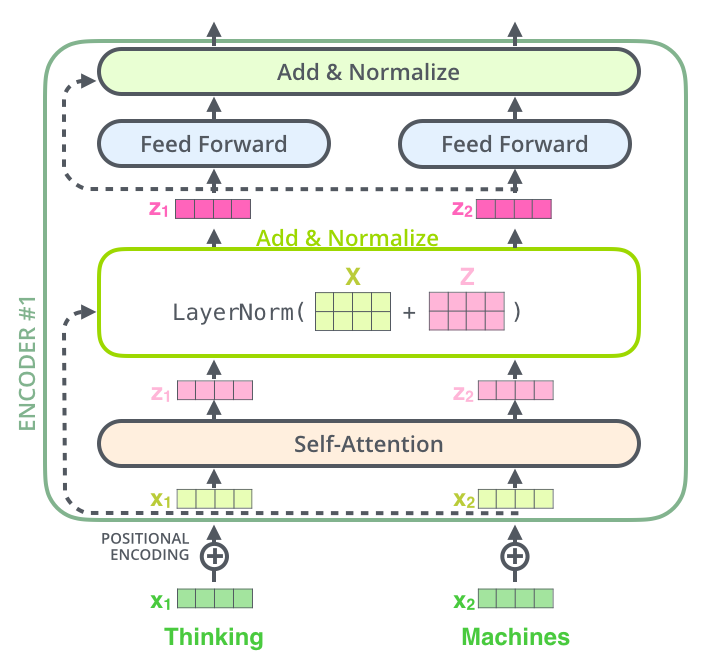

In [ ]:

class TransformerBlock(nn.Module):
    """
    Transformer block, a fundamental component of the transformer model.

    A transformer block consists of multi-head self-attention, layer normalization,
    and a feed-forward neural network with dropout.

    Args:
        embed_dim (int): The dimensionality of the input embeddings.
        ff_hidden_size (int): The size of the hidden layer in the feed-forward network.
        num_heads (int): The number of attention heads in the multi-head attention mechanism. Defaults to 8.
        dropout_rate (float): Dropout rate for regularization. Defaults to 0.2.

    Attributes:
        attention (MultiHeadAttention): Multi-head self-attention module.
        norm1 (nn.LayerNorm): Layer normalization for the first layer.
        norm2 (nn.LayerNorm): Layer normalization for the second layer.
        feed_forward (FeedForwardNetwork): Feed-forward neural network module.
        dropout1 (nn.Dropout): Dropout layer for the first layer.
        dropout2 (nn.Dropout): Dropout layer for the second layer.
    """

    def __init__(self, embed_dim, ff_hidden_size, num_heads=8, dropout_rate=0.2):
        """
        Initializes the TransformerBlock module.

        Args:
            embed_dim (int): The dimensionality of the input embeddings.
            ff_hidden_size (int): The size of the hidden layer in the feed-forward network.
            num_heads (int): The number of attention heads in the multi-head attention mechanism. Defaults to 8.
            dropout_rate (float): Dropout rate for regularization. Defaults to 0.2.
        """

        super(TransformerBlock, self).__init__()
        # Multi-head self-attention mechanism
        self.attention = MultiHeadAttention(embed_dim, num_heads)
        # Layer normalization for the first layer
        self.norm1 = nn.LayerNorm(embed_dim)
        # Layer normalization for the second layer
        self.norm2 = nn.LayerNorm(embed_dim)

        # Using the improved FeedForwardNetwork
        self.feed_forward = FeedForwardNetwork(embed_dim, ff_hidden_size, dropout_rate)

         # Dropout layers for regularization
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)

        # Initialize weights
        self.apply(_init_weights)

    def forward(self, value, key, query):
        """
        Forward pass of the TransformerBlock module.

        Args:
            value (torch.Tensor): The input tensor of values, of shape `(seq_len, batch_size, embed_dim)`.
            key (torch.Tensor): The input tensor of keys, of shape `(seq_len, batch_size, embed_dim)`.
            query (torch.Tensor): The input tensor of queries, of shape `(seq_len, batch_size, embed_dim)`.

        Returns:
            torch.Tensor: The tensor after applying the transformer block, of shape `(seq_len, batch_size, embed_dim)`.
        """
        # Layer normalization for the first layer
        norm_query = self.norm1(query)
        # Multi-head self-attention mechanism
        attention_out = self.attention(value, key, norm_query)
        # Skip connection and dropout for the first layer
        query = query + self.dropout1(attention_out) # Residual connection
        # Layer normalization for the second layer
        norm_query = self.norm2(query)
        # Feed-forward neural network
        feed_fwd_out = self.feed_forward(norm_query)
        # Skip connection and dropout for the second layer
        query = query + self.dropout2(feed_fwd_out) # Residual connection

        return query

In [ ]:
class TransformerEncoder(nn.Module):
    """
    Transformer Encoder module for processing sequential data.

    Args:
        seq_len (int): Length of the input sequence.
        vocab_size (int): Size of the vocabulary.
        embed_dim (int): Dimension of the embedding.
        num_layers (int): Number of encoder layers. Defaults to 2.
        ff_hidden_size (int): Size of the hidden layer in the feed-forward network. Defaults to 2048.
        num_heads (int): Number of heads in multi-head attention. Defaults to 8.

    Returns:
        out (torch.Tensor): Output of the encoder.
    """
    def __init__(self, seq_len, vocab_size, embed_dim, num_layers=2, ff_hidden_size=2048, num_heads=8):
        super(TransformerEncoder, self).__init__()

        # Embedding layer to convert input indices to dense vectors
        self.embedding_layer = Embedding(vocab_size, embed_dim)
        # Positional encoding to provide positional information to the model
        self.positional_encoder = PositionalEncoding(seq_len, embed_dim)
        # Stack multiple Transformer blocks as encoder layers
        self.layers = nn.ModuleList([TransformerBlock(embed_dim, ff_hidden_size, num_heads) for i in range(num_layers)])

    def forward(self, x):
        # Embedding layer converts input indices to dense vectors
        embed_out = self.embedding_layer(x)
        # Add positional encoding to the embedded sequence
        out = self.positional_encoder(embed_out)
        # Pass the sequence through multiple Transformer blocks
        for layer in self.layers:
            out = layer(out, out, out)

        return out  #32x10x512

# The decoder

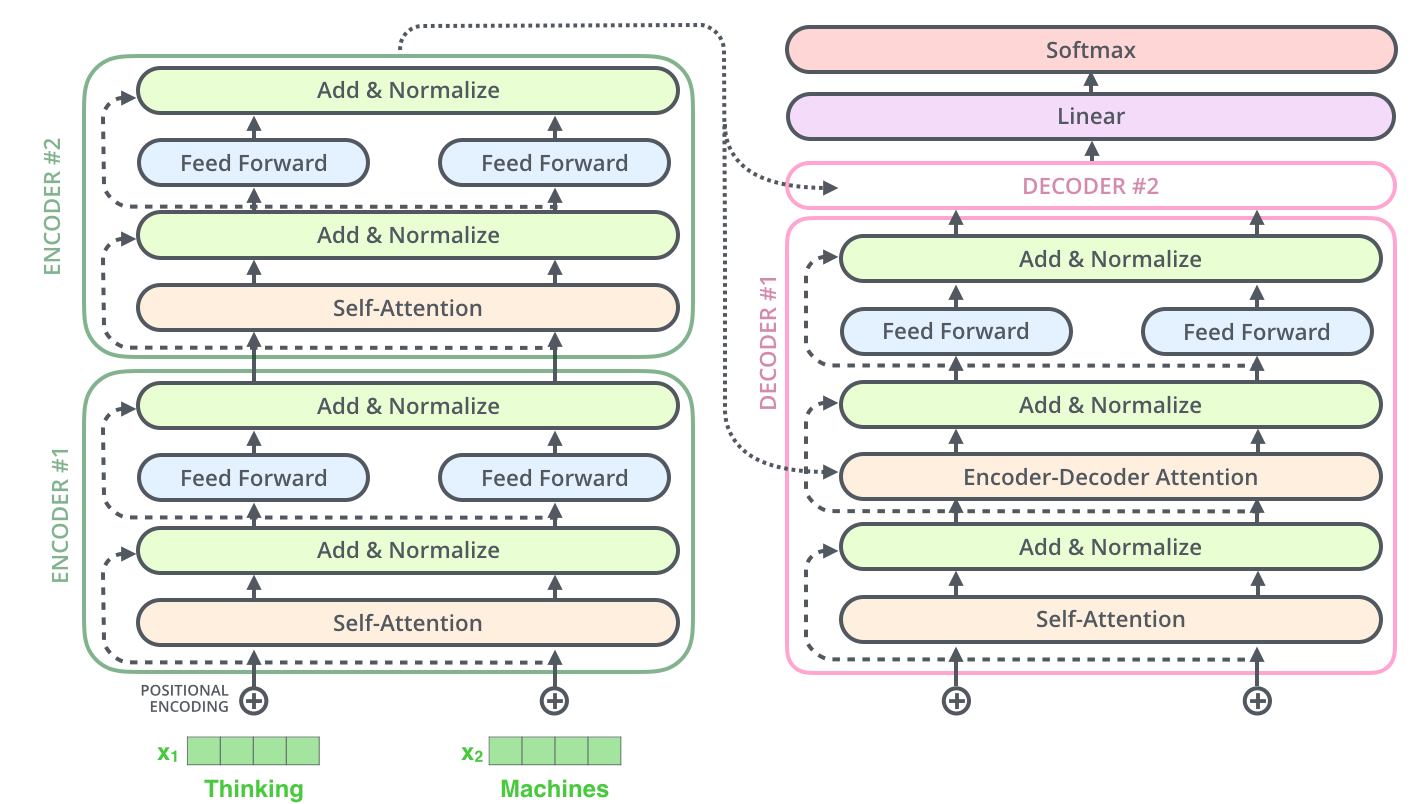

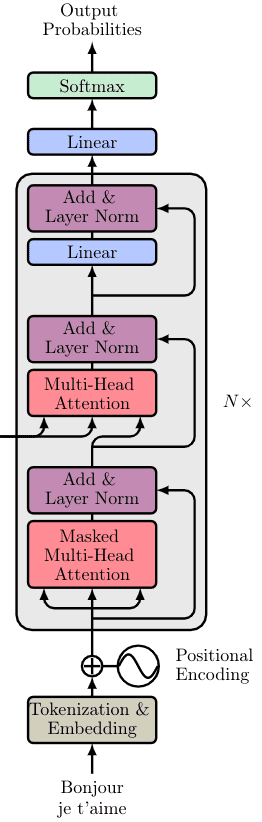


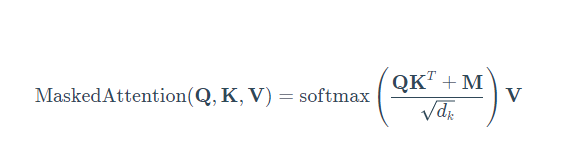

In [ ]:
class DecoderBlock(nn.Module):
    """
    Decoder Block module for processing target sequences in the Transformer Decoder.

    Args:
        embed_dim (int): Dimension of the embedding.
        ff_hidden_size (int): Size of the hidden layer in the feed-forward network.
        num_heads (int): Number of heads in multi-head attention. Defaults to 8.
        dropout_rate (float): Dropout rate for regularization. Defaults to 0.2.

    Returns:
        out (torch.Tensor): Output tensor representing processed target sequences.
    """
    def __init__(self, embed_dim, ff_hidden_size, num_heads=8, dropout_rate=0.2):
        super(DecoderBlock, self).__init__()
        # Multi-head attention layer for attending to different parts of the sequence
        self.attention = MultiHeadAttention(embed_dim, num_heads)

        # Layer normalization for stabilizing and accelerating the training process
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

        # TransformerBlock now correctly receives ff_hidden_size
        self.transformer_block = TransformerBlock(embed_dim, ff_hidden_size, num_heads, dropout_rate)

        # Dropout layer for regularization
        self.dropout = nn.Dropout(dropout_rate)

        # Initialize weights using Xavier/Glorot initialization
        self.apply(_init_weights)

    def forward(self, key, query, value, mask):
        """
        Forward pass of the DecoderBlock module.

        Args:
            key (torch.Tensor): Key tensor for attention mechanism.
            query (torch.Tensor): Query tensor for attention mechanism.
            value (torch.Tensor): Value tensor for attention mechanism.
            mask (torch.Tensor): Mask for attention mechanism.

        Returns:
            out (torch.Tensor): Output tensor representing processed target sequences.
        """
        # Apply layer normalization to the query tensor
        norm_query = self.norm1(query)
        # Multi-head attention mechanism to attend to different parts of the sequence
        attention = self.attention(value, value, norm_query, mask=mask)
        # Apply dropout for regularization and add the attention output to the original query
        query = query + self.dropout(attention)
        # Pass the processed tensors through the TransformerBlock
        out = self.transformer_block(key, query, value)

        return out # Output tensor representing processed target sequences

In [ ]:
class TransformerDecoder(nn.Module):
    """
    Transformer Decoder module for generating target sequences.

    Args:
        target_vocab_size (int): Vocabulary size of the target language.
        embed_dim (int): Dimension of the embedding.
        seq_len (int): Length of the input sequence.
        num_layers (int): Number of decoder layers. Defaults to 2.
        ff_hidden_size (int): Size of the hidden layer in the feed-forward network. Defaults to 2048.
        num_heads (int): Number of heads in multi-head attention. Defaults to 8.
        dropout_rate (float): Dropout rate for regularization. Defaults to 0.2.

    Returns:
        out (torch.Tensor): Output vector representing generated target sequences.
    """
    def __init__(self, target_vocab_size, embed_dim, seq_len, num_layers=2, ff_hidden_size=2048, num_heads=8, dropout_rate=0.2):
        super(TransformerDecoder, self).__init__()
        # Embedding layer to convert target indices to dense vectors
        self.word_embedding = nn.Embedding(target_vocab_size, embed_dim)
        # Positional encoding to provide positional information to the model
        self.position_embedding = PositionalEncoding(seq_len, embed_dim)
        # Stack multiple Decoder blocks as decoder layers
        self.layers = nn.ModuleList(
            [
                DecoderBlock(embed_dim, ff_hidden_size, num_heads, dropout_rate)
                for _ in range(num_layers)
            ]
        )
        # Fully connected layer for generating output logits
        self.fc_out = nn.Linear(embed_dim, target_vocab_size)
        # Dropout layer for regularization
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x, enc_out, mask):
        """
        Forward pass of the TransformerDecoder module.

        Args:
            x (torch.Tensor): Input vector from the target language.
            enc_out (torch.Tensor): Output from the encoder layer.
            mask (torch.Tensor): Mask for decoder self-attention.

        Returns:
            out (torch.Tensor): Output vector representing generated target sequences.
        """
        # Embedding layer converts target indices to dense vectors
        x = self.word_embedding(x)  # Shape: (batch_size, seq_len, embed_dim)
        # Add positional encoding to the embedded sequence
        x = self.position_embedding(x) # Shape: (batch_size, seq_len, embed_dim)
        # Apply dropout for regularization
        x = self.dropout(x)

        # Pass the sequence through multiple Decoder blocks
        for layer in self.layers:
            x = layer(enc_out, x, enc_out, mask)

        # Generate output logits using a fully connected layer
        out = F.softmax(self.fc_out(x), dim=-1)

        return out # Shape: (batch_size, seq_len, target_vocab_size)

# The Transformer

In [ ]:
class Transformer(nn.Module):
    """
    Transformer model for sequence-to-sequence tasks.

    Args:
       embed_dim (int): Dimension of the embedding.
       src_vocab_size (int): Vocabulary size of the source language.
       target_vocab_size (int): Vocabulary size of the target language.
       seq_length (int): Length of input sequence.
       num_layers (int): Number of encoder and decoder layers. Defaults to 2.
       ff_hidden_size (int): Size of the hidden layer in the feed-forward network. Defaults to 2048.
       num_heads (int): Number of heads in multihead attention. Defaults to 8.

    Attributes:
        target_vocab_size (int): Vocabulary size of the target language.
        encoder (TransformerEncoder): Encoder module of the Transformer.
        decoder (TransformerDecoder): Decoder module of the Transformer.
    """

    def __init__(self, embed_dim, src_vocab_size, target_vocab_size, seq_length, num_layers=2, ff_hidden_size=2048, num_heads=8):
        super(Transformer, self).__init__()

        self.target_vocab_size = target_vocab_size

        # Initialize TransformerEncoder and TransformerDecoder
        self.encoder = TransformerEncoder(seq_length, src_vocab_size, embed_dim, num_layers=num_layers, ff_hidden_size=ff_hidden_size, num_heads=num_heads)
        self.decoder = TransformerDecoder(target_vocab_size, embed_dim, seq_length, num_layers=num_layers, ff_hidden_size=ff_hidden_size, num_heads=num_heads)


    def make_trg_mask(self, trg):
        """
        Create a target mask for attention mechanism.

        Args:
            trg (torch.Tensor): Target sequence.

        Returns:
            trg_mask (torch.Tensor): Target mask.
        """
        batch_size, trg_len = trg.shape
        # returns the lower triangular part of matrix filled with ones
        trg_mask = torch.tril(torch.ones((trg_len, trg_len))).expand(
            batch_size, 1, trg_len, trg_len
        )
        return trg_mask

    def decode(self,src,trg):
        """
        Inference step to generate predictions for the target sequence.

        Args:
            src (torch.Tensor): Input to the encoder.
            trg (torch.Tensor): Input to the decoder.

        Returns:
            out_labels (list): List of predicted labels for the target sequence.
        """
        trg_mask = self.make_trg_mask(trg)
        enc_out = self.encoder(src)
        out_labels = []
        batch_size,seq_len = src.shape[0],src.shape[1]
        #outputs = torch.zeros(seq_len, batch_size, self.target_vocab_size)
        out = trg
        for i in range(seq_len): #10
            out = self.decoder(out,enc_out,trg_mask) #bs x seq_len x vocab_dim
            # taking the last token
            out = out[:,-1,:]

            out = out.argmax(-1)
            out_labels.append(out.item())
            out = torch.unsqueeze(out,axis=0)


        return out_labels

    def forward(self, src, trg):
        """
        Forward pass of the Transformer model.

        Args:
            src (torch.Tensor): Input to the encoder.
            trg (torch.Tensor): Input to the decoder.

        Returns:
            outputs (torch.Tensor): Final vector representing probabilities of each target word.
        """
        trg_mask = self.make_trg_mask(trg)
        enc_out = self.encoder(src)

        outputs = self.decoder(trg, enc_out, trg_mask)
        return outputs

In [ ]:
# Set hyperparameters
src_vocab_size = 11
target_vocab_size = 11
num_layers = 6
seq_length = 12
embed_dim = 512
ff_hidden_size = 2048  # Feed-forward hidden layer size
num_heads = 8

# Define sample input sequences
src_sequence = torch.tensor([[0, 2, 5, 6, 4, 3, 9, 5, 2, 9, 10, 1],
                             [0, 2, 8, 7, 3, 4, 5, 6, 7, 2, 10, 1]])
target_sequence = torch.tensor([[0, 1, 7, 4, 3, 5, 9, 2, 8, 10, 9, 1],
                                [0, 1, 5, 6, 2, 4, 7, 6, 2, 8, 10, 1]])
# Print the shape of input sequences
print("Shape of source sequence:", src_sequence.shape)
print("Shape of target sequence:", target_sequence.shape)

# Instantiate the Transformer model with the specified parameters
model = Transformer(embed_dim=embed_dim, src_vocab_size=src_vocab_size,
                    target_vocab_size=target_vocab_size, seq_length=seq_length,
                    num_layers=num_layers, ff_hidden_size=ff_hidden_size, num_heads=num_heads)

# Print the model architecture
print("Transformer Model:")
print(model)

Shape of source sequence: torch.Size([2, 12])
Shape of target sequence: torch.Size([2, 12])
Transformer Model:
Transformer(
  (encoder): TransformerEncoder(
    (embedding_layer): Embedding(
      (embedding): Embedding(11, 512)
    )
    (positional_encoder): PositionalEncoding()
    (layers): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadAttention(
          (query_projection): Linear(in_features=64, out_features=64, bias=False)
          (key_projection): Linear(in_features=64, out_features=64, bias=False)
          (value_projection): Linear(in_features=64, out_features=64, bias=False)
          (output_projection): Linear(in_features=512, out_features=512, bias=True)
        )
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (feed_forward): FeedForwardNetwork(
          (fc1): Linear(in_features=512, out_features=2048, bias=True)
          (fc2): Line

#Resources for Class 17

- https://jalammar.github.io/illustrated-transformer/
- https://nlp.seas.harvard.edu/2018/04/03/attention.html
- https://docs.google.com/presentation/d/1AVoWMfpmNgZaIBSEMnSHeIkT6lN7QqduAVKL14cAU7A/edit#slide=id.g2e24ab687b0_1_112
- https://docs.google.com/presentation/d/1D4NMCqMqvfVSo6OFxcO76-mAbj5fbQLjz9pQ_pNNe9Y/edit#slide=id.g2df7911c582_0_218
